In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import thinkstats2
import thinkplot
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, confusion_matrix, precision_score, recall_score, log_loss
from sklearn.model_selection import train_test_split

In [19]:
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as sm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import binarize
import math

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Assignment 4 - Classification

For this assignment, you'll need to perform a classification on a dataset, as well as do some prep work on the data. 

The exact steps of what you need to do are flexible and up to you to some degree, however you should consider some of the important things we've mentioned recently, such as:
<ul>
<li> Is the target balanced?
<li> Are there missing or erroneous values?
<li> Are there categorical or numerical features?
<li> Is there colinearity?
<li> Are there outliers?
<li> Should we normalize? 
<li> Do the distributions of the features give any indication that some may need work? 
</ul>

Basically, the data is in the original, potentially dirty, format, and you need to find what should be cleaned, and do the cleaning. There is not one "right" answer to what has to be done, and you'll probably need to do it with at least something of an iterative process - find an issue, correct it, check the data, repeat.

<b>The target that we are predicting is the loan_status. </b>

## Grading

The grades will be broken down as follows:
<ul>
<li> <b>30%</b> - a working predictive model with a reasonable level of accuracy. 
    <ul>
    <li> For the accuracy part, it will not be explicitly graded, but compared to all the others. If you're in the same general range, that's good - if yours is drastically less accurate (or, I guess more accurate), then I'll adjust. There won't be a comparison of "this person is 72.3% and this person is only 71.8% accurate, they fail."
    <li> This data is larger than most of the small sample sets, so random variations due to train-test splits shouldn't be too bad. (If you're a keener you could loop)
    <li> I will use the F1 score as the accuracy metric. 
    </ul>
<li> <b>40%</b> - a clear and readable description of what steps you took to prepare the data, and a brief not on the rationale behind it. Did you do a log transformation to a skewed feature, did you remove outliers, did you remove a feature that has a lot of missing values? Please put this somewhere obvious and readable, consider the goal of the assignment to explain your process to me. 
    <ul>
    <li> E.g. "The target data was imbalanced, so I tried several resampling methods and chose the one with the highest accuracy of the resulting model", "the feature X had the same value for 95% of records, so I dropped it". 
    <li> In this, please also state if you see a group that appears to be a good credit risk, and a group that is a bad credit risk, and indicate the evidence showing that. Please do this other than the most simplistic way - more money = better credit. If there are no such groups, state why you think this. This will likely be about 3 - 5 statements or points, you should provide evidence from the data, but it does not need to be an essay. (You may want to consider this question after you're pretty much done with the data prep and modelling.)
    </ul>
<li> <b>30%</b> - allowing your model to be "deployed". At the bottom of this file there is a small block of code to load in some test data (that I have), and calculate your accuracy. Your contribution to this part is to have a model that is ready to make predictions. Some specifics to consider:
    <ul>
    <li> The test data will be in exactly the same format as the dataset you're given. So any steps that you took to prepare your data for modelling will need to be mirroed here, so the new  data can be predicted. The easiest way to do this is to use a pipeline, but it is up to you. Remember the model only accepts data that is in a certain format - the one that you had the data in when it was trained, so when making predictions you need to make sure that is true. 
    <li> Since I'm providing test data, and your task is to just create a model, think about how that might impact your train-test splitting, both as you're developing and for the final product. 
    <li> Once the model is trained it should predict any data that is in the right format, so I should be able to provide any proper dataset, click run on that testing cell, and get predictions. I will not be doing anything that will purposefully make this harder or trickier, like including data that has errors or is in the wrong format, I just split the entire set of data, reserved part of it to test accuracy, and gave the rest to you. Things that you've changed (e.g. dropping a column, one-hot encoding) do need to be replicated at some point before the model can accept the new data to predict. In general we <b>do</b> want to check in our processing that our input is valid, this is kind of a junior introduction to that. 
    </ul>
</ul

## Load Credit Data

In [20]:
df = pd.read_csv("train.csv")
df.sample(5)

,Unnamed: 0,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
20160,26952,31,120000,MORTGAGE,6.0,MEDICAL,A,28000,8.90,0,0.23,N,9
22400,32334,70,30000,RENT,0.0,DEBTCONSOLIDATION,D,1000,17.49,1,0.03,Y,21
9851,10017,23,65000,MORTGAGE,7.0,EDUCATION,A,9000,7.88,0,0.14,N,3
5338,20935,30,80000,RENT,0.0,MEDICAL,A,8900,6.17,0,0.11,N,10
16991,20422,27,58000,RENT,0.0,EDUCATION,C,4600,13.99,0,0.08,N,8


In [21]:
df.describe()

,Unnamed: 0,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,26064.000000,26064.000000,2.606400e+04,25350.000000,26064.000000,23575.000000,26064.000000,26064.000000,26064.000000
mean,16307.473258,27.738375,6.602795e+04,4.791440,9595.886088,11.006839,0.216812,0.170264,5.805210
std,9396.129345,6.381305,6.265098e+04,4.100277,6321.894580,3.245217,0.412082,0.106673,4.055158
min,0.000000,20.000000,4.080000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,8202.250000,23.000000,3.879375e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,16324.500000,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,24458.250000,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,32580.000000,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


<AxesSubplot:xlabel='loan_status', ylabel='count'>

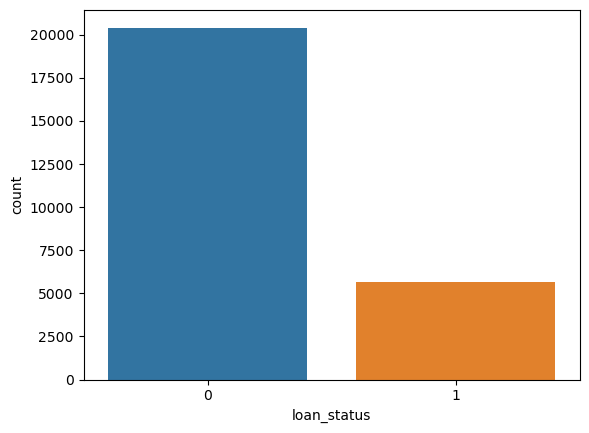

In [22]:
sns.countplot(data = df, x = 'loan_status')

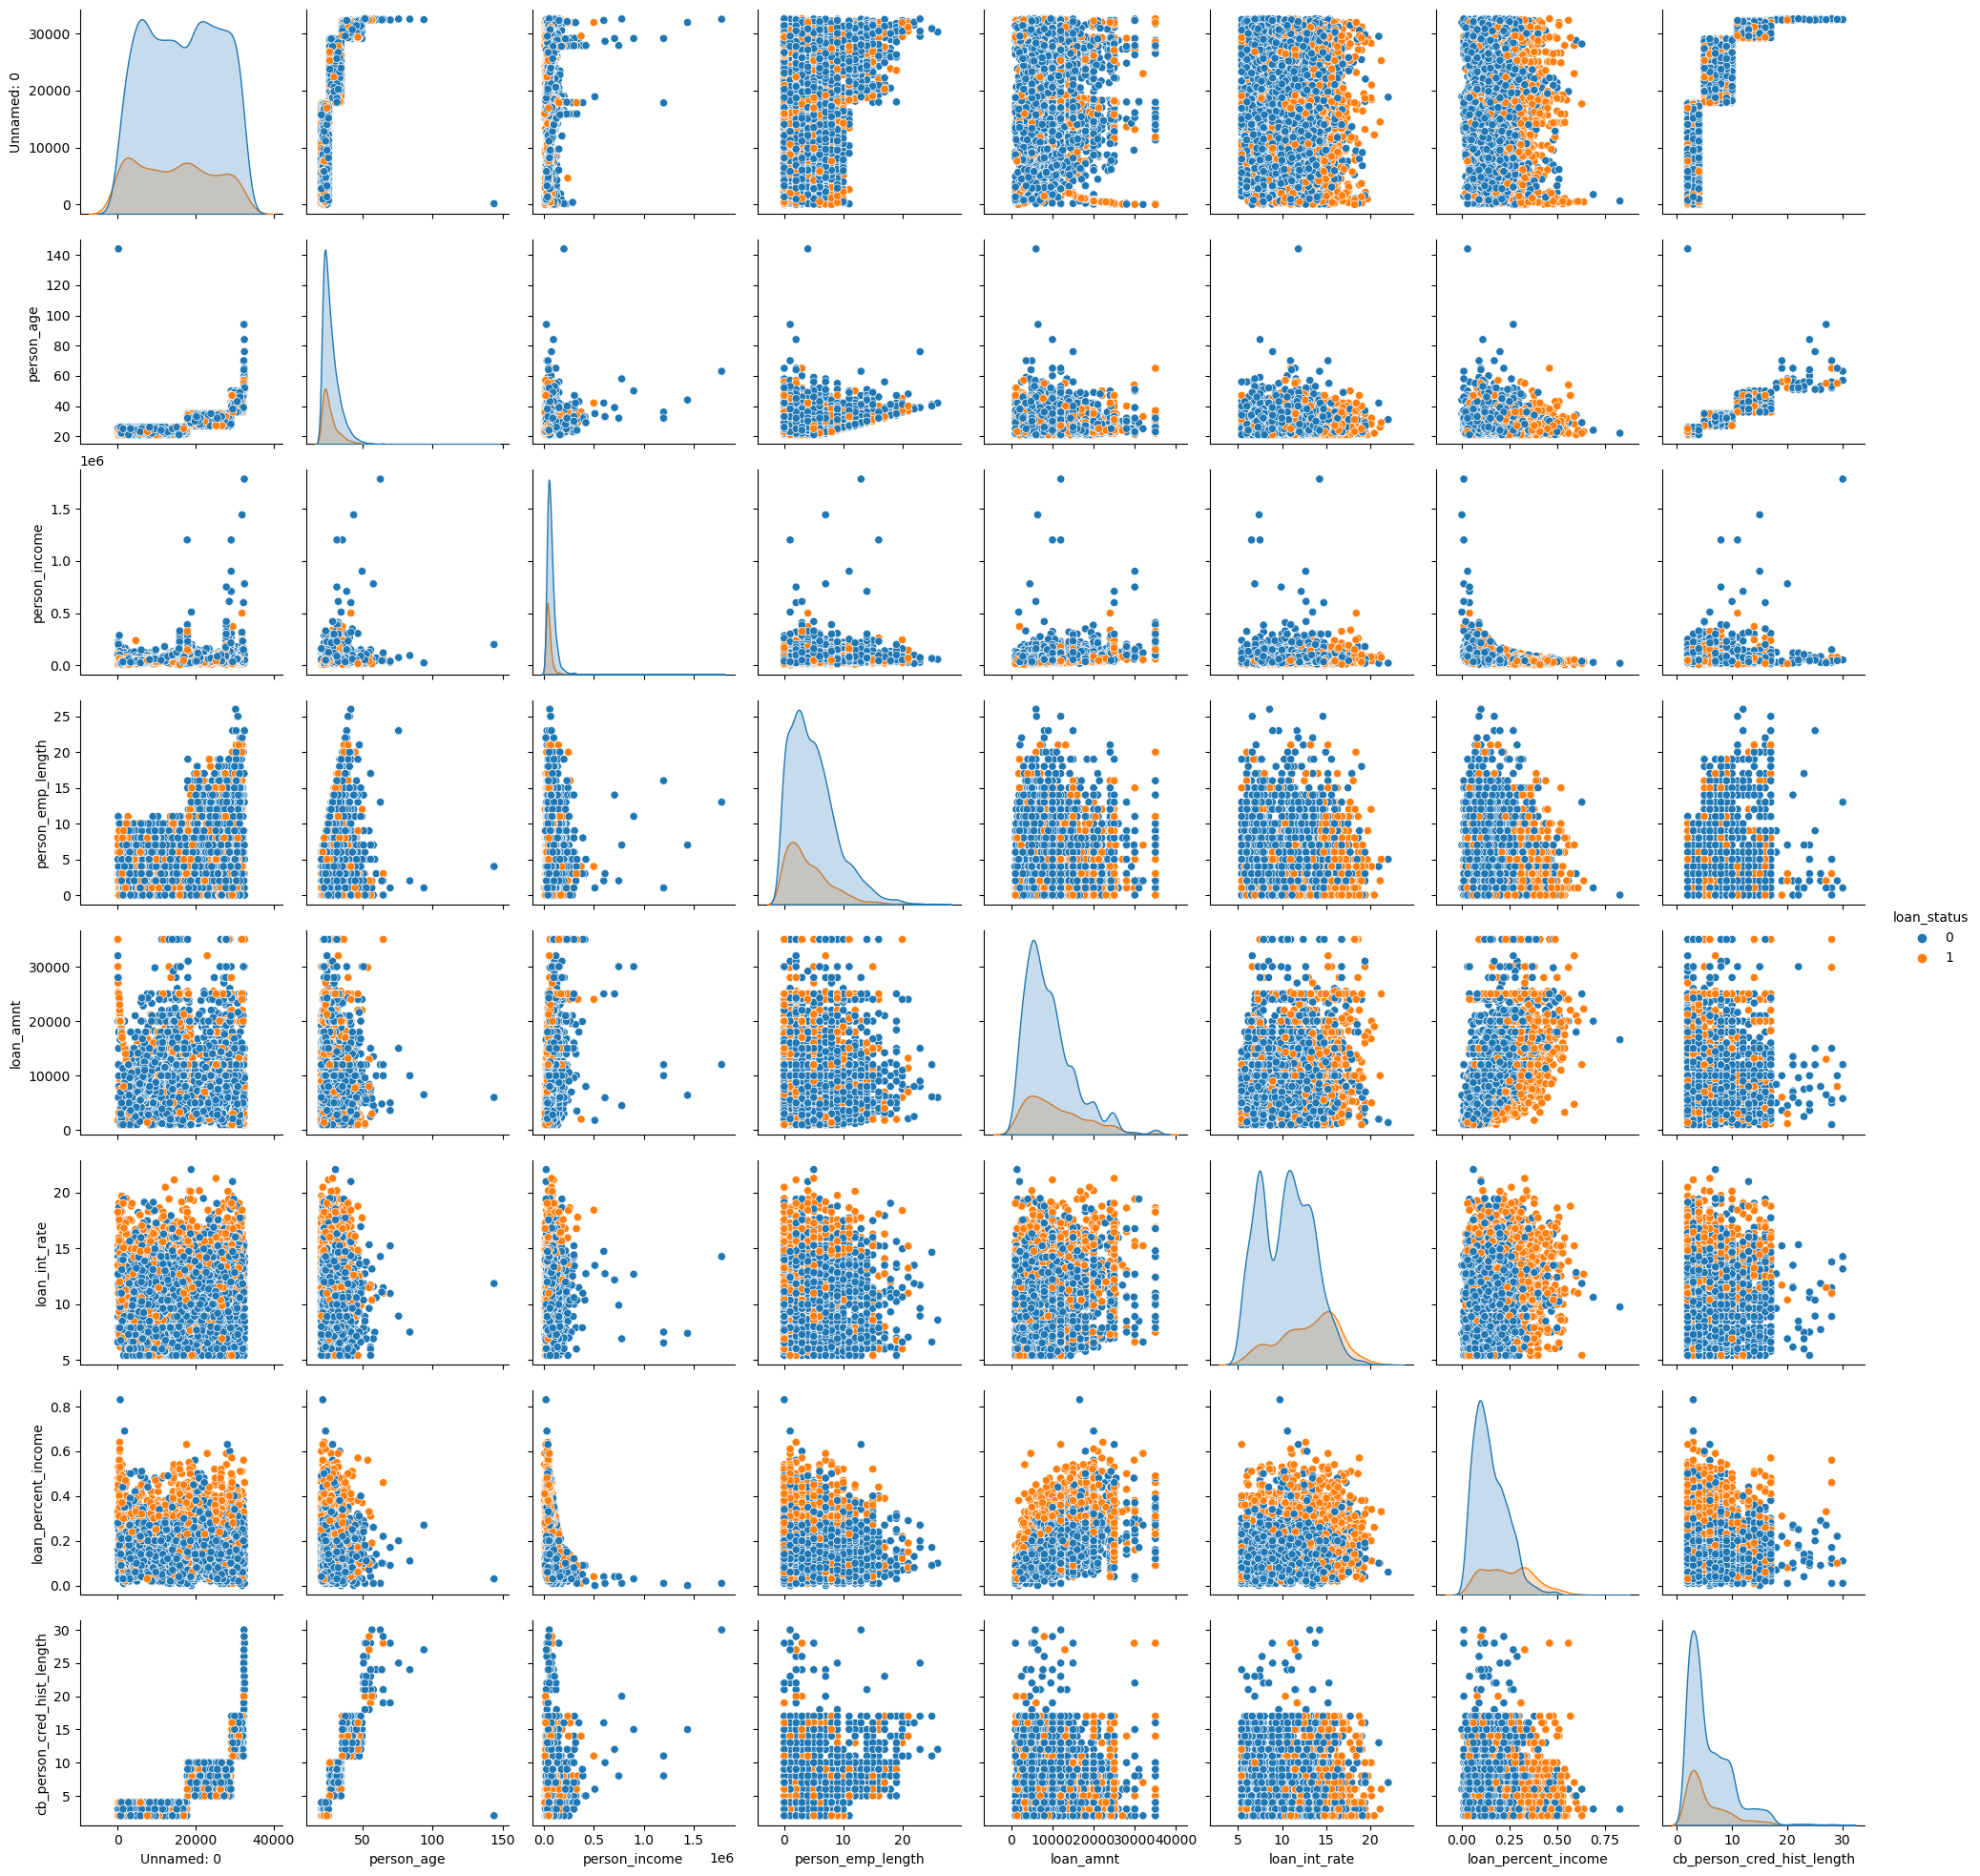

In [23]:
# visualize the data to check any outlier
sns.pairplot(df.sample(5000), hue="loan_status")

In [24]:
# check if data has any null
df.isna().sum()

Unnamed: 0                       0
person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              714
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 2489
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [25]:
# Remove Some Outliers, some people's age that over 100
# some incomes are extremely high. Maybe it is not an error, but we want to focus on normal range of data
df = df[df['person_age'] < 70]
df = df[df['person_income'] < 1000000]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26040 entries, 0 to 26063
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  26040 non-null  int64  
 1   person_age                  26040 non-null  int64  
 2   person_income               26040 non-null  int64  
 3   person_home_ownership       26040 non-null  object 
 4   person_emp_length           25327 non-null  float64
 5   loan_intent                 26040 non-null  object 
 6   loan_grade                  26040 non-null  object 
 7   loan_amnt                   26040 non-null  int64  
 8   loan_int_rate               23556 non-null  float64
 9   loan_status                 26040 non-null  int64  
 10  loan_percent_income         26040 non-null  float64
 11  cb_person_default_on_file   26040 non-null  object 
 12  cb_person_cred_hist_length  26040 non-null  int64  
dtypes: float64(3), int64(6), object

In [26]:
## Correlation Matrix, if they are highly correlated, not good for prediction.
corr = df.corr()
corr.style.background_gradient()
corr.style.background_gradient().set_precision(2)

C:\Users\Elsa\AppData\Local\Temp\ipykernel_2000\1642500873.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient().set_precision(2)


,Unnamed: 0,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
Unnamed: 0,1.00,0.76,0.21,0.19,0.10,-0.00,-0.06,-0.07,0.77
person_age,0.76,1.00,0.14,0.17,0.05,0.00,-0.02,-0.04,0.88
person_income,0.21,0.14,1.00,0.17,0.36,-0.00,-0.18,-0.32,0.11
person_emp_length,0.19,0.17,0.17,1.00,0.11,-0.05,-0.08,-0.05,0.15
loan_amnt,0.10,0.05,0.36,0.11,1.00,0.15,0.11,0.57,0.04
loan_int_rate,-0.00,0.00,-0.00,-0.05,0.15,1.00,0.34,0.12,0.01
loan_status,-0.06,-0.02,-0.18,-0.08,0.11,0.34,1.00,0.38,-0.02
loan_percent_income,-0.07,-0.04,-0.32,-0.05,0.57,0.12,0.38,1.00,-0.04
cb_person_cred_hist_length,0.77,0.88,0.11,0.15,0.04,0.01,-0.02,-0.04,1.00


In [27]:
# drop these columns that have null data and correlation were too high
df = df.drop(columns = ['person_emp_length', 'loan_int_rate', 'cb_person_cred_hist_length', 'person_age', 'Unnamed: 0', 'cb_person_default_on_file'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26040 entries, 0 to 26063
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   person_income          26040 non-null  int64  
 1   person_home_ownership  26040 non-null  object 
 2   loan_intent            26040 non-null  object 
 3   loan_grade             26040 non-null  object 
 4   loan_amnt              26040 non-null  int64  
 5   loan_status            26040 non-null  int64  
 6   loan_percent_income    26040 non-null  float64
dtypes: float64(1), int64(3), object(3)
memory usage: 1.6+ MB


In [28]:
# change the object data type to category
df[["person_home_ownership", "loan_intent", "loan_grade"]] = df[["person_home_ownership", "loan_intent", "loan_grade"]].astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26040 entries, 0 to 26063
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   person_income          26040 non-null  int64   
 1   person_home_ownership  26040 non-null  category
 2   loan_intent            26040 non-null  category
 3   loan_grade             26040 non-null  category
 4   loan_amnt              26040 non-null  int64   
 5   loan_status            26040 non-null  int64   
 6   loan_percent_income    26040 non-null  float64 
dtypes: category(3), float64(1), int64(3)
memory usage: 1.1 MB


In [29]:
# Encode the categorical varaiables. 
df = pd.get_dummies(df, drop_first = True)
df.sample(5)

,person_income,loan_amnt,loan_status,loan_percent_income,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G
18745,25200,3000,0,0.12,0,0,1,0,0,0,0,1,0,0,0,0,0,0
9463,43200,13800,0,0.32,0,1,0,0,0,0,0,1,1,0,0,0,0,0
2011,103000,14000,0,0.14,0,0,0,0,0,0,0,0,1,0,0,0,0,0
15237,52000,3600,0,0.07,0,0,1,0,0,0,1,0,1,0,0,0,0,0
16530,66300,7000,1,0.09,0,0,1,0,0,1,0,0,1,0,0,0,0,0


In [30]:
sampler = SVMSMOTE(n_jobs=-1)
y = np.array(df["loan_status"]).reshape(-1,1)
x = np.array(df.drop(columns={"loan_status"}))
print(y.shape, x.shape)

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.33)

#Look at relative imbalance after split
xtrain_samp, ytrain_samp = sampler.fit_resample(xtrain, ytrain)

#Normalize data
scaler = StandardScaler()
xtrain_norm = scaler.fit_transform(xtrain_samp)
xtest_norm = scaler.transform(xtest)

(26040, 1) (26040, 17)


F1: 0.7781427291728873
Acc: 0.9135443332557598
Recall: 0.7104689203925845
Precision: 0.86006600660066


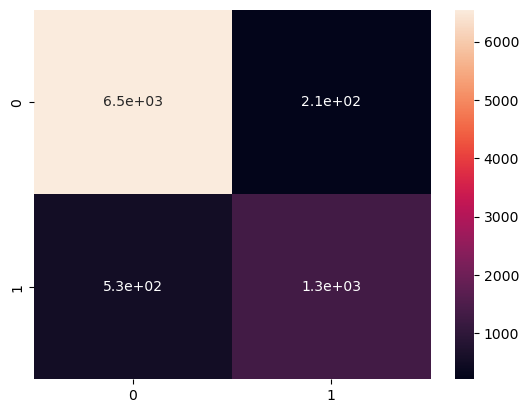

In [31]:
#Train model 1
model = RandomForestClassifier(n_jobs=-1).fit(xtrain_norm,ytrain_samp.ravel())

#Make predictions
preds = model.predict(xtest_norm)

#Generate 1/0 results and show results
labels = binarize(np.array(preds).reshape(-1,1), threshold=.5)
conf_matrix = confusion_matrix(ytest,labels)
sns.heatmap(conf_matrix, annot=True)

print("F1:",f1_score(ytest, labels))
print("Acc:",accuracy_score(ytest, labels))
print("Recall:",recall_score(ytest, labels))
print("Precision:",precision_score(ytest, labels))

Use MinMaxScaler first to see the F1 and accuracy; it showed: 

F1: 0.6380525304292121

Acc: 0.8685129159878985

therefore, StandardScaler has a better prediction. 

created the Logistic Regression, the F1 result was: 0.6483060109289618

Ultimately, the Random Forest Classifier showed better accuracy.

### Accuracy Test

Replace the green part with whatever you need to transform the fresh data into the format needed for your model to predict. 

<b>Note:</b> you could test and make sure that things are working OK here by taking part of your dataset, saving it in a separate CSV, and running it through here as a piece of test data. The accuracy results would be useless, but you'd confirm that the model works properly. 

In [32]:
d_test = pd.read_csv("test.csv")

d_test = d_test[d_test['person_age'] < 70]
d_test = d_test[d_test['person_income'] < 1000000]
d_test = d_test.drop(columns = ['person_emp_length', 'loan_int_rate', 'cb_person_cred_hist_length', 'person_age', 'Unnamed: 0', 'cb_person_default_on_file'])
d_test[["person_home_ownership", "loan_intent", "loan_grade"]] = d_test[["person_home_ownership", "loan_intent", "loan_grade"]].astype("category")

d_test = pd.get_dummies(d_test, drop_first = True)

#sampler = SVMSMOTE(n_jobs=-1)
ytest = np.array(d_test["loan_status"]).reshape(-1,1)
xtest = np.array(d_test.drop(columns={"loan_status"}))

#Normalize data
scaler = StandardScaler()
xtest_norm = scaler.fit_transform(xtest)

#Make predictions
preds = model.predict(xtest_norm)
prediction_labels = binarize(np.array(preds).reshape(-1,1), threshold=.5)
print(ytest.shape, xtest.shape)

######################
# Insert whatever you need to do to prep the data here. 
# It might be nothing if you have a big pipeline. 
# Ensure that at the end your data is in two arrays - xtest and ytest
# Ensure the name of your final model is "model"
# Each should contain the ENTIRE x or y dataset in the test data. 
#
# This part should be reusable - any dataset in this format should just run
# and generate predictions and accuracy stats. 
# Please DO NOT do any train-test splitting here. 
#######################

# This should work once you're done, as is. 
# uncomment the stuff below when ready to run.
print("F1:",f1_score(ytest, prediction_labels))
conf_matrix = confusion_matrix(ytest, prediction_labels)
sns.heatmap(conf_matrix, annot=True)

FileNotFoundError: [Errno 2] No such file or directory: 'test.csv'